# Dimensionality reduction

The ```HyperAnalysis``` widget allows to perform dimensionality reduction, and to identify groups of pixels representative of specific spectral signatures called end-members. The widget loads information from the output of the ```Sediment``` widget.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import napari
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from napari.utils.notebook_display import nbscreenshot

from napari_sediment.widgets.hyperanalysis_widget import HyperAnalysisWidget
plt.style.use('default')

import os
synth_path = Path(os.path.expanduser("~")).joinpath('Sediment_synthetic')

In [3]:
viewer =napari.Viewer()
self = HyperAnalysisWidget(viewer)
viewer.window.add_dock_widget(self);

In [4]:
export_folder = synth_path.joinpath('sediment_export')
self._on_click_select_export_folder(alternate_path=export_folder)
self.import_project()
self._on_click_select_all()

C:\Users\micha\Documents\Github_Desktop\napari-sediment-fork-mh\src\napari_sediment\widgets\hyperanalysis_widget.py:641: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  self.viewer.layers['pure_members'].color = {ind: line_colors[ind] for ind in range(0, self.viewer.layers['pure_members'].data.max()+1)}


## Main

In the Main tab, one can select again the project exported in the ```SedimentWidget```. The widget only loads data corresponding to the analysis ROIs defined previously. If multiple Main ROIs were defined, one can switch between those using ```Selected ROI```.

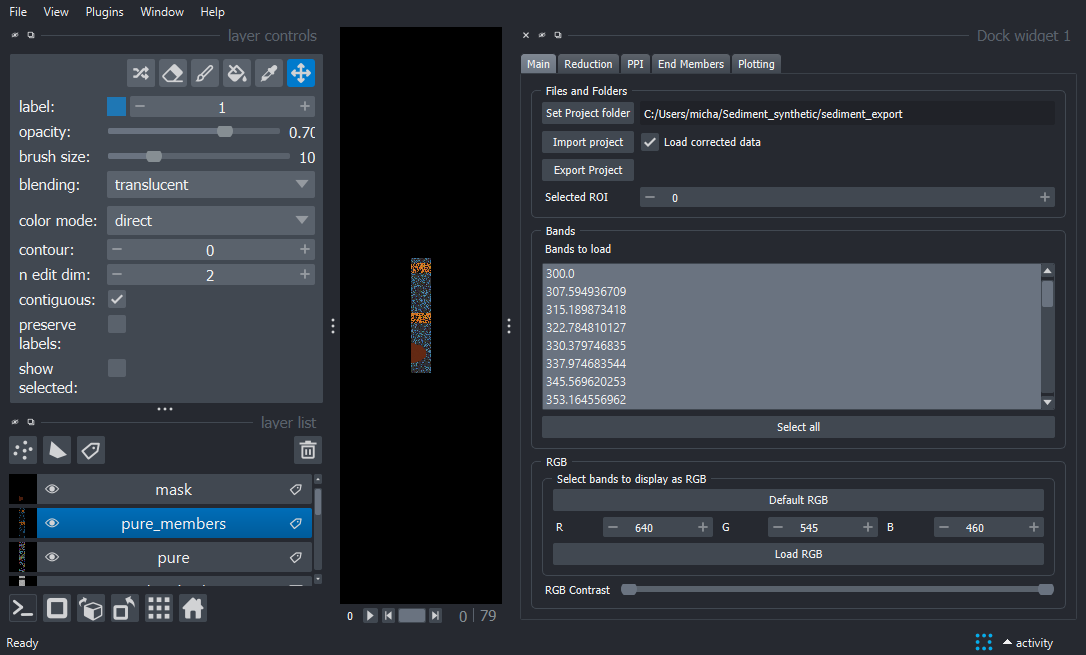

In [5]:
nbscreenshot(viewer)

Since in principle only a fraction of the dataset is loaded, all bands are imported at this stage. However the same interface as in the ```Sediment``` widget allows to control the selected bands.

## Reduction

Here you can perform a spectral reduction of the data, i.e. identify a subset of bands that captures the most relevant information in the data. The methods used here coming from the [spectral](https://www.spectralpython.net/index.html) package.

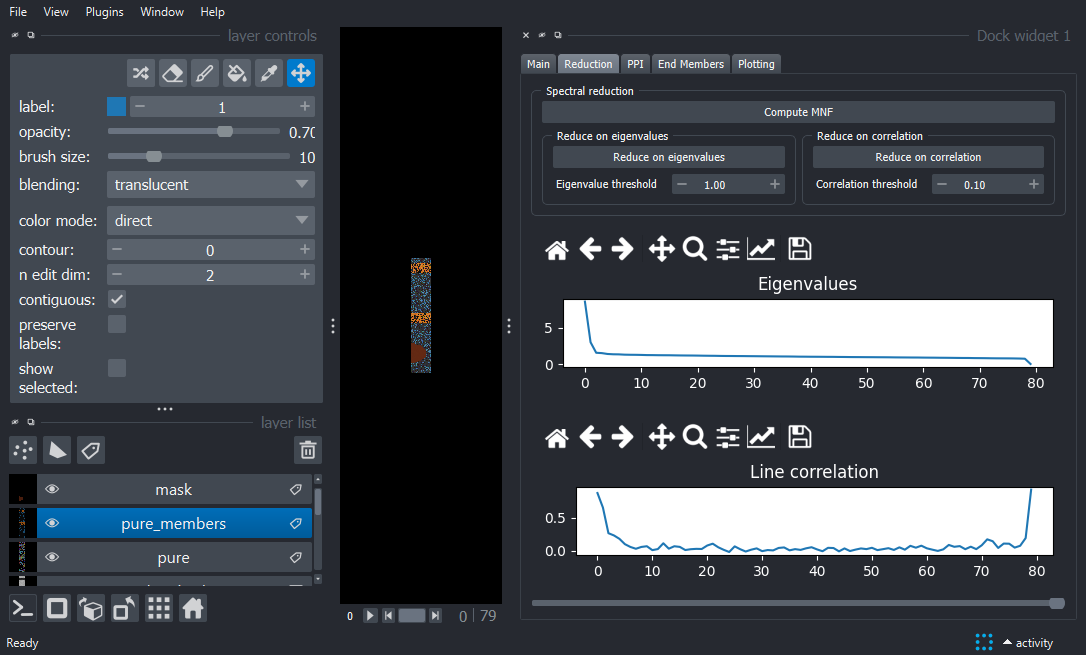

In [6]:
self.tabs.setCurrentIndex(1)
nbscreenshot(viewer)

Reduction is performed in the following way:

1. A minimal noise fraction analysis is performed. This performs a sort of PCA that maximized signal to noise ratio and transforms the bands in a new "space" where the first series (high eigenvalues) contain a lot of information and the last bands contain only noise.

In [7]:
self._on_click_mnfr()

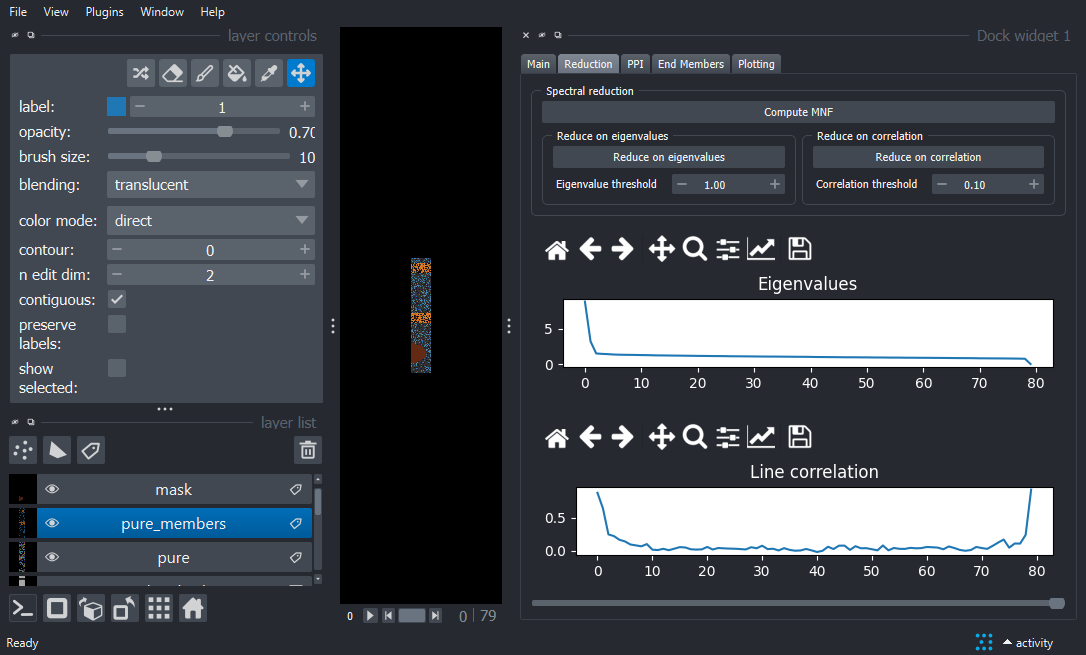

In [8]:
nbscreenshot(viewer)

2. Once this sorting has been done, one needs to cutoff bands with low information. This can be done in two ways:
    - either by cutting off bands with low eigenvalues i.e. low information
    - or by analyzing how much vertical correlation exists in each band. If a band contains only noise, no correlation between rows is expected whereas if there are structures (as expected in sediment images) correlation is high
    
Setting the threshold on the eigenvalues or correlation can be done by setting a value in the threshold boxes or by interactively selecting a threshold on the plots visible above by clicking in the plot.

Note that artifacts can generate high correlations in some of the last bands. In that case, one can use the slider at the bottom to cutoff the region considered to compute the correlation threshold.

Once a threshold is selected, click on one of the ```Reduce on... ``` buttons. This creates a new layer ```denoised``` with the reduced data.

**Note that because the layer ```ìmcube``` is still present, the slider at the bottom of the viewer still indicates all bands. But if you turn off all layers except for ```denoised```, you will notice that the denoised stack is eventually empty (here after slice 4).**

In [9]:
self.spin_correlation_threshold.setValue(0.1)
self.slider_corr_limit.setValue(50)
self._on_click_reduce_mnfr_on_correlation()

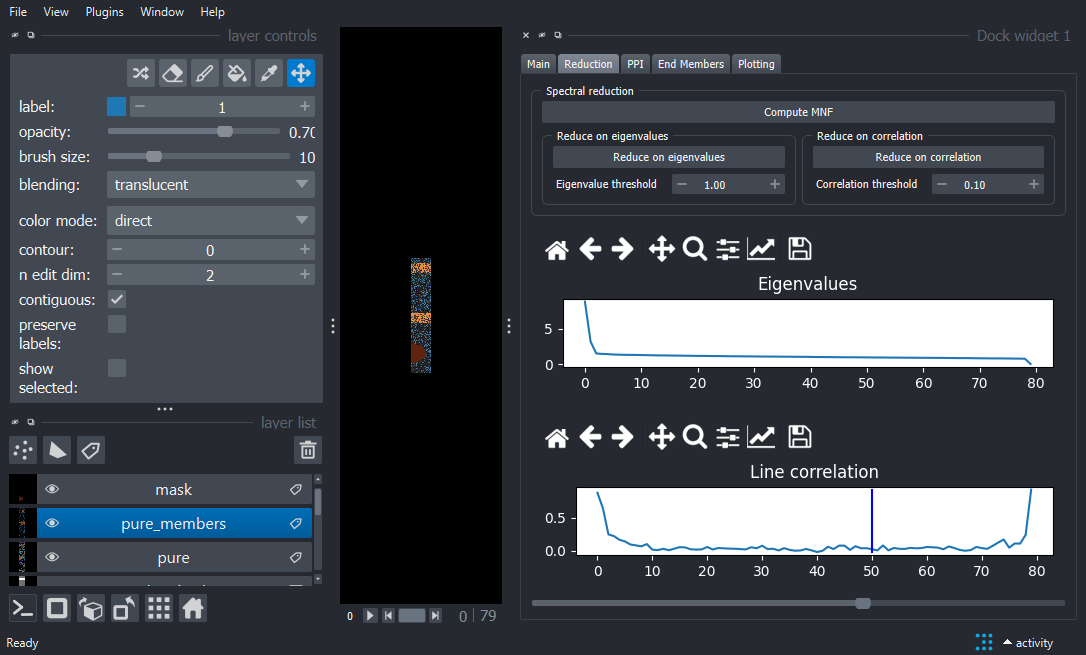

In [10]:
nbscreenshot(viewer)

## PPI

Now that we deal with a dataset of reduced size we can detect **pure pixels**, i.e. pixels that lie on the edge of the new space defined by the MNF transform. Those pixels should be representative of specific elements present in the sample.

Three parameters can be set:
- Threshold PPI counts: have many times a single pixel should be identified as pure to be considered
- Threshold PPI project: at each PPI round one can choose to keep only the best candidate (purest pixel) or that pixel and those close to it. Using higher values here means that more pixels will be classified as pure (even though they are less pure).

After clicking on PPI, two new layers indicating selected pixels appear:

In [11]:
self.ppi_iterations.setValue(15000)
self._on_click_ppi()

C:\Users\micha\Documents\Github_Desktop\napari-sediment-fork-mh\src\napari_sediment\widgets\hyperanalysis_widget.py:641: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  self.viewer.layers['pure_members'].color = {ind: line_colors[ind] for ind in range(0, self.viewer.layers['pure_members'].data.max()+1)}


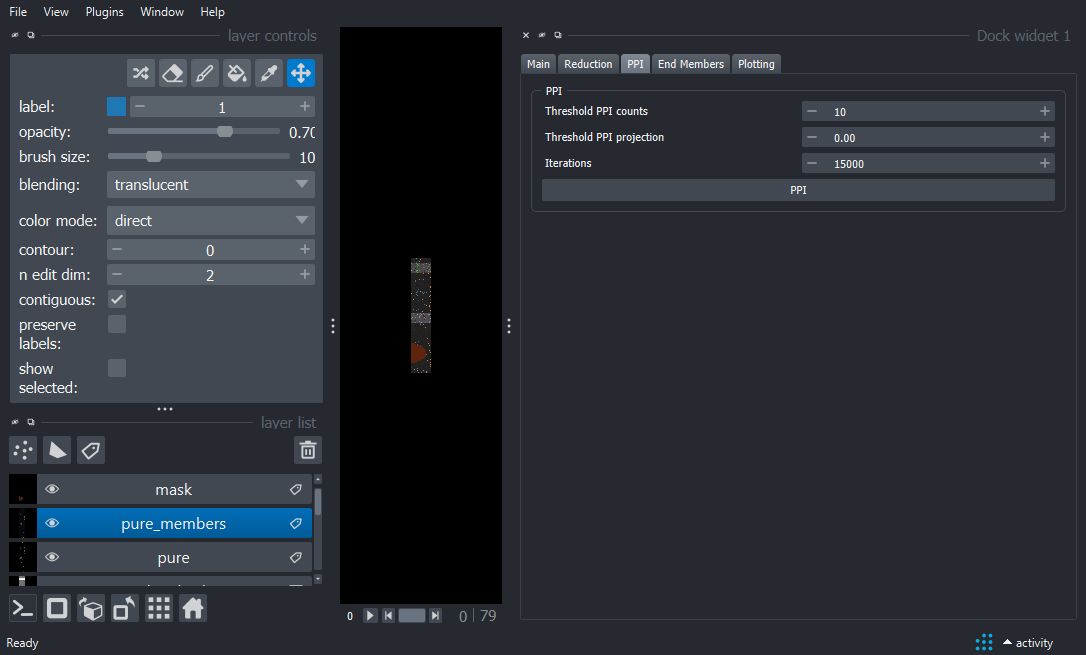

In [12]:
self.tabs.setCurrentIndex(2)
nbscreenshot(viewer)

The ```pure``` layer displays selected pure pixels and colors them by how many times they have been selected during the N iterations performed. The ```pure_members``` colors pure pixels according to their clustering as end-members as explained below.

## End Members

Finally, all the pure pixels have to be clustered in groups with similar spectra. Clustering is achieved using the DBSCAN algorithm for which one can set the maximal distance limit above which two points cannot belong to the same cluster (eps). Adjusting this value can therefore increase (small values) or decrease (large values) the number of clusters. Given the stochastic nature of clustering, the dependency between eps and number of cluster is not strictly monotonic.

Finally the spectra of all pure pixels belonging to a cluster is averaged and plotted. As we can see in this simplified example, the two "signal" spectra are identified (orange and green) while the other pixels represent background.

Two options allow to modify the end-member plot:
- curves can be smoothed using the Savitzky-Golay method using a windows of variable size
- an approximate continuous signal can be subtracted from the data

C:\Users\micha\Documents\Github_Desktop\napari-sediment-fork-mh\src\napari_sediment\widgets\hyperanalysis_widget.py:641: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  self.viewer.layers['pure_members'].color = {ind: line_colors[ind] for ind in range(0, self.viewer.layers['pure_members'].data.max()+1)}


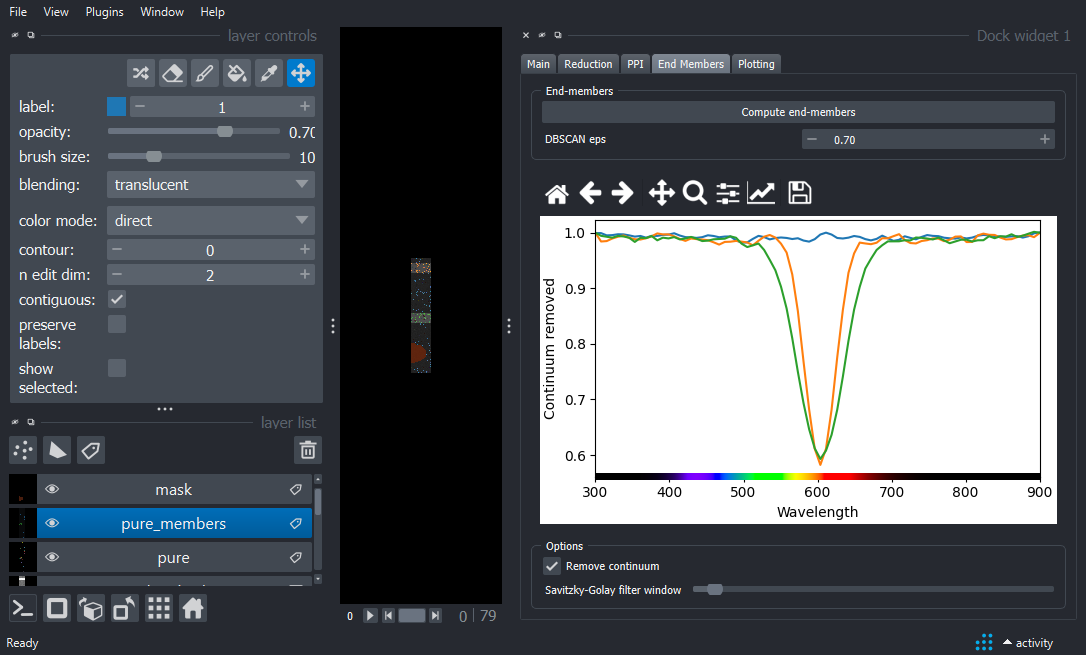

In [13]:
self.tabs.setCurrentIndex(3)
self.qspin_endm_eps.setValue(0.7)
self._on_click_update_endmembers()
nbscreenshot(viewer)

We see here that the pixel coloring reflects that end-member clustering: we have two absorption regions in green and orange and background pixels in blue.

## Plotting

As in the previous plugin, we can here visualize full spectra for individual pixels. One can just hover over the image by pressing the Shift key, and pixel spectra will appear in the plot.

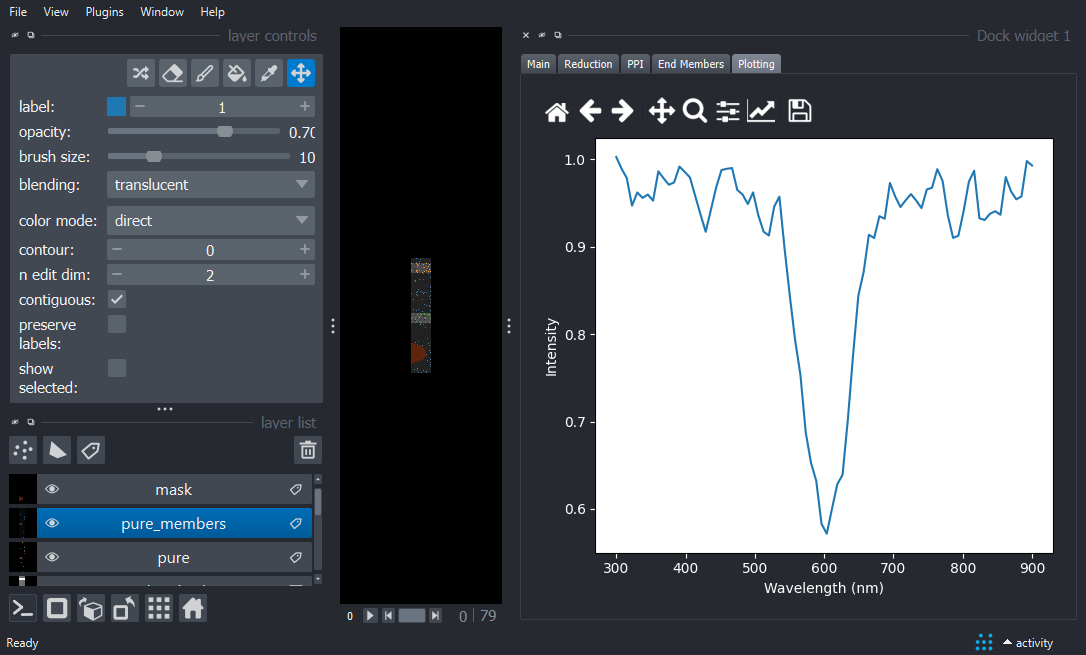

In [14]:
self.tabs.setCurrentIndex(4)

self.spectral_pixel = self.viewer.layers['imcube'].data[:, 60, 10]
self.update_spectral_plot()

nbscreenshot(viewer)

## Saving

The end-member information is important in the next step in order to define indices that quantify spectra. As in the other widgets, come back to the ```Main``` tab and click on ```Export Project```.

In [15]:
self.tabs.setCurrentIndex(0)
self.save_index_project()

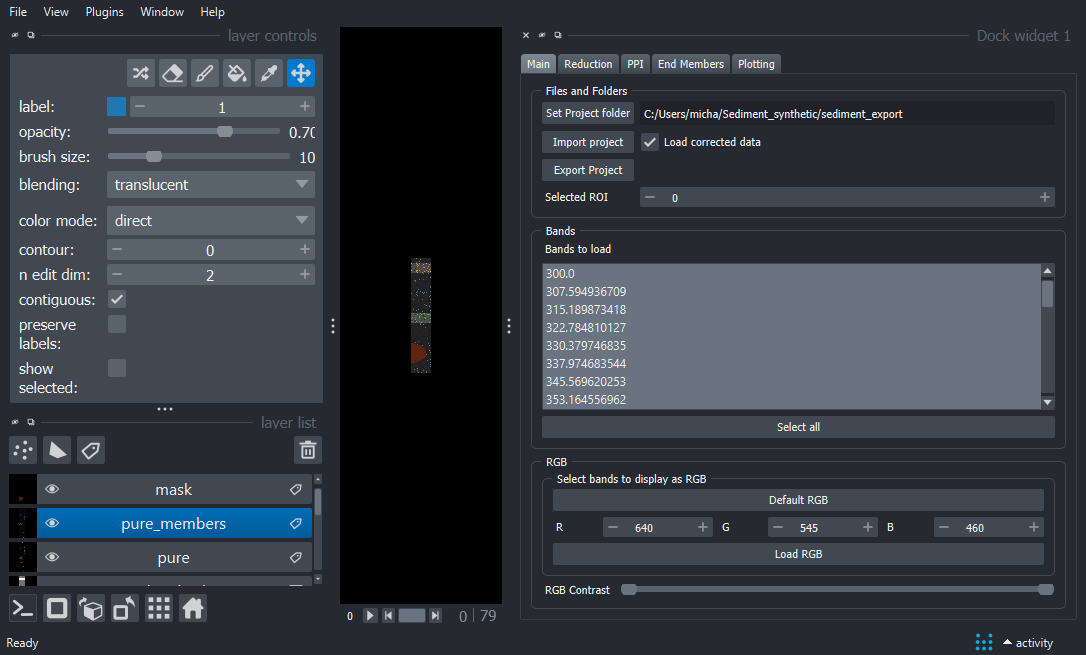

In [16]:
nbscreenshot(viewer)